## Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Data Info:
1. The datasets contains transactions made by credit cards in September 2013 by european cardholders.
2. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 
3. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
4. There are 28 PCA transformed features.
5. Only 'time'(seconds elapsed between transactions) and 'amount' have not been transformed.
6. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Purpose
Identify fraudulent credit card transactions.
Prioritize correctly finding fraud rather than correctly labeling non-fraudulent transactions. Can be a black box supervised algorithm since the main priority is correct prediction.

## Analysis and Results
The ideal result I was looking to accomplish with this model was to capture all credit card frauds while minimizing the false classification of legitimate transactions. Since I was dealing with a massively unbalanced dataset I tested both under-sampling the majority class and up-sampling the minority class with SMOTE. Under-sampling with logistic regression and random forest classifier resulted in similar results. Both did an excellent job of identifying credit card frauds, but a miserable job of minimizing false positives. They both had an F1 score of 0.96 for non-fraud transactions, F1 of 0.08 for fraudulent transcactions after logistic regression, and for fraudulent transcactions after random forest classification. Looking to improve on the models, I upsampled the data with SMOTE and performed a random forest classification. SMOTE greatly improved the random forest classification precision with a score of 0.88. However there was a reduction in recall down to 0.80.  While a confusion matrix can be misleading with unbalanced data, I still feel it can be informative. Out of the 85296 non-fraudulent transactions tested only 16 were called false positives, 28 out of 147 fraudulent charges were missed. The models false positive rate is acceptable but the all important false negative rate is not.   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve,recall_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import scikitplot as skplt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/patrickgonzales/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [2]:
# import credit card data
file = "/Users/patrickgonzales/Documents/thinkfulCourse/bootcamp/unit_3/creditcard.csv"
df = pd.read_csv(file, delimiter=",")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## EDA:
1. Missing data?
2. Do we have outliers?
3. What is the distribution of each variable? 
4. Is there a relationship between independent variables?
5. Do the indpendent variables require rescaling?

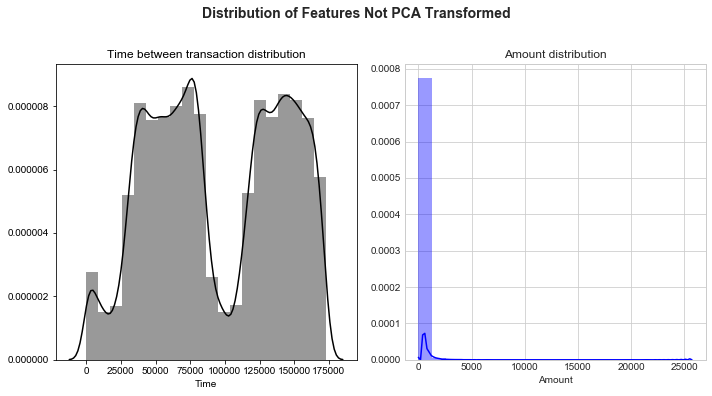

In [4]:
# 1. count missing values
df.isnull().sum()

# 2. check if values make sense
df.describe()

#3. histogram of Time and amount variables
plt.figure(figsize=[10,5])
plt.subplot(1, 2, 1)
sns.set_style("whitegrid")
sns.distplot(df.Time, bins=20, color='black')
plt.xlabel('Time')
plt.title('Time between transaction distribution');

plt.subplot(1, 2, 2)
sns.set_style("whitegrid")
sns.distplot(df.Amount, bins=20, color='blue')
plt.xlabel('Amount')
plt.title('Amount distribution')
plt.suptitle("Distribution of Features Not PCA Transformed", fontweight="bold", fontsize=14, x=0.5, y=1.09)
plt.tight_layout()
plt.show()

#### EDA Results (Questions 1-3)
1. No missing values in dataset. 
2. No noticeable outliers in V1-V28 PCA transformed features. There is a time-between-transaction that is 0 and amount-taken-out that is 0. Need to look at those. Perhaps it is a mistake or just a fraudulent transaction.
3. Looks like the time variable follows a bimodal distribution. Need to keep in mind that this variable may consist of two different groups. Also the Amount variable has at least one large outlier. Need to see whats going on with those data points.

*****Not shown: Looked at histograms of all V1-V28 PCA transformed values and they are a mix of normal distributions and left/right skewed distributions.


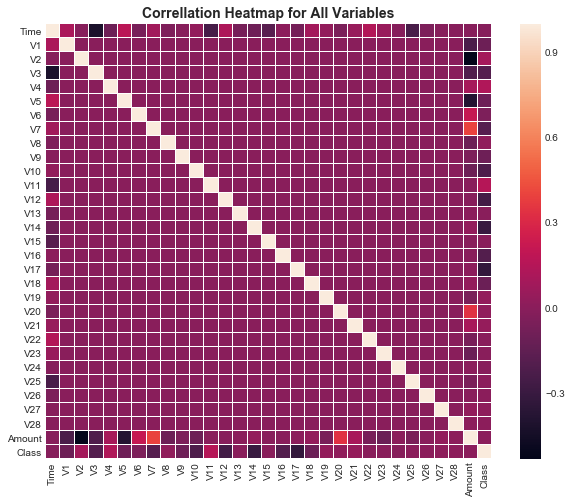

,Time,Amount,V2,V3,V5,V7,V20
Time,1.000000,-0.010596,-1.059333e-02,-4.196182e-01,1.730721e-01,8.471437e-02,-5.086602e-02
Amount,-0.010596,1.000000,-5.314089e-01,-2.108805e-01,-3.863563e-01,3.973113e-01,3.394034e-01
V2,-0.010593,-0.531409,1.000000e+00,2.512175e-16,-2.039868e-16,3.966486e-16,-9.309954e-16
V3,-0.419618,-0.210880,2.512175e-16,1.000000e+00,-1.436514e-15,2.168574e-15,-9.429297e-16
V5,0.173072,-0.386356,-2.039868e-16,-1.436514e-15,1.000000e+00,-4.209851e-16,2.076048e-16
V7,0.084714,0.397311,3.966486e-16,2.168574e-15,-4.209851e-16,1.000000e+00,1.744242e-16
V20,-0.050866,0.339403,-9.309954e-16,-9.429297e-16,2.076048e-16,1.744242e-16,1.000000e+00


In [5]:
# 4. look at variable relationships with heatmap/correlation matrix
plt.figure(figsize=[10,8])
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values,linewidths=0.01 )
plt.title("Correllation Heatmap for All Variables", fontweight="bold", fontsize=14)
plt.show()

#look at R2 values of 
df_corr_subset = df[['Time', 'Amount', 'V2', 'V3', 'V5', 'V7','V20']]
df_corr_subset.corr()
                    

#### EDA results (Questions 4)
I am not worried about correlation between independent variables. As expected, the PCA transformed variables do not correlate with each other. Amount and time do not correlate with each other. Also, the "V" variables do not correlate with Time or amount by a value thats concerning.

In [6]:
# 5. Rescale data?
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### EDA results (Question 5)
May need to rescale amount and time. Try logistic regression or using tree based algorithms first- no need to scale with those. 

## Deal with class imbalance
1. Try Random undersampling (multiple randomizations)
2. SMOTE (minority oversampling technique)

In [7]:
# 1. Random undersampling to deal with class imbalance
no_frauds = len(df[df['Class'] == 1])
non_fraud_indices = df[df.Class == 0].index
random_indices = np.random.choice(non_fraud_indices,no_frauds, replace=False)
fraud_indices = df[df.Class == 1].index
under_sample_indices = np.concatenate([fraud_indices,random_indices])
under_sample = df.loc[under_sample_indices]

## Run Supervised algorithms
1. logistic regression
2. Random forest classifier

### Logistic Regression

In [18]:
#logistic regression on undersampled data
X_under = under_sample.loc[:,under_sample.columns != 'Class']
y_under = under_sample.loc[:,under_sample.columns == 'Class']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under,y_under,test_size = 0.3, random_state = 0)

#inititate logistic regression, fit, predict
lr_under = LogisticRegression()
lr_under.fit(X_under_train,y_under_train)
y_under_pred = lr_under.predict(X_under_test)

# recall and accuracy for undersampled (balanced data) logistic regression
print('Recall for undersampled test data:',recall_score(y_under_test,y_under_pred))
print('Accuracy for undersampled test data:',accuracy_score(y_under_test,y_under_pred))

Recall for undersampled test data: 0.9387755102040817
Accuracy for undersampled test data: 0.9391891891891891


In [19]:
# predictions for original unbalanced data using logistic regression
X = df.drop(['Class'], axis=1)
y = df[['Class']]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

# check how well the algorithm predicted with Accuracy, recall, precision, and F1 score.
y_pred = lr_under.predict(X_test)
print('Recall for original unbalanced test data:',recall_score(y_test,y_pred))
print('Accuracy for original unbalanced test data:',accuracy_score(y_test,y_pred))
print('\n')
print('---Classification Report---')
print(classification_report(y_test,y_pred))

Recall for original unbalanced test data: 0.9455782312925171
Accuracy for original unbalanced test data: 0.9601020563416547


---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.96      0.98     85296
          1       0.04      0.95      0.08       147

avg / total       1.00      0.96      0.98     85443



Good recall, poor precision. Labeling too many non-fraudulent charges as fraud. Need to fix this.

## Random Forest classification

In [20]:
# now test out Random forest algorithm on balanced undersampled data
rf_under = RandomForestClassifier(n_estimators=30, random_state=3, class_weight="balanced")
rf_under.fit(X_under_train,y_under_train)
y_rf_under_pred = rf_under.predict(X_under_test)

# recall and accuracy for undersampled (balanced data) random forest with default
print('Recall for under sampled test data:',recall_score(y_under_test,y_rf_under_pred))
print('Accuracy for under sampled test data:',accuracy_score(y_under_test,y_rf_under_pred))

Recall for under sampled test data: 0.9387755102040817
Accuracy for under sampled test data: 0.9493243243243243


In [21]:
# predictions for original unbalanced data using random forest
X = df.drop(['Class'], axis=1)
y = df[['Class']]

y_rf_pred = rf_under.predict(X_test)
print('Recall for original unbalanced test data:',recall_score(y_test,y_rf_pred))
print('Accuracy for original unbalanced test data:',accuracy_score(y_test,y_rf_pred))
print('\n')
print('---Classification Report---')
print(classification_report(y_test,y_rf_pred))

Recall for original unbalanced test data: 0.9659863945578231
Accuracy for original unbalanced test data: 0.9668668000889482


---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.97      0.98     85296
          1       0.05      0.97      0.09       147

avg / total       1.00      0.97      0.98     85443



Looks very similar to logistic regression. Need to try upsampling now. 

## Upsample with SMOTE and run Random Forest Classification

In [12]:
# split training and test data
x_train, x_val, y_train, y_val = train_test_split(X, y,test_size = .3,random_state=12)

# initiate SMOTE
sm = SMOTE(random_state=1, ratio = 1.0)

# upsample on training data with SMOTE
x_train_smote, y_train_smote = sm.fit_sample(x_train, y_train)

# initiate RF classifier
rf = RandomForestClassifier(n_estimators=10, random_state=12, criterion="entropy", class_weight={0: 0.5, 1: 2})

# fit on upsampled training data
rf.fit(x_train_smote, y_train_smote)

#make predictions on unbalanced data
y_rf_smote_pred = rf.predict(x_val)

#check predictions on unbalanced test data
print('Recall for original unbalanced test data:',recall_score(y_val,y_rf_smote_pred))
print('Accuracy for original unbalanced test data:',accuracy_score(y_val,y_rf_smote_pred))
print('---Classification Report---')
print(classification_report(y_val,y_rf_smote_pred))

Recall for original unbalanced test data: 0.8095238095238095
Accuracy for original unbalanced test data: 0.9994850368081645
---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.88      0.81      0.84       147

avg / total       1.00      1.00      1.00     85443



In [13]:
#look at confusion matrix to see if theres an acceptable level of false positives
confusion_matrix(y_val, y_rf_smote_pred)

array([[85280,    16],
       [   28,   119]])

In [14]:
score = cross_val_score(rf, x_val, y_val, cv=10)

print('Cross Val scores: ',score,'\n')
print("Cross validation Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Cross Val scores:  [0.99953189 0.99964892 0.99941486 0.99941486 0.99964892 0.99894675
 0.99941479 0.99882945 0.99929767 0.99906356] 

Cross validation Accuracy: 1.00 (+/- 0.00)


Much more acceptable precision now, but the accuracy is worse. 